<a href="https://colab.research.google.com/github/YusufCanDemirkol/youtube-video-cover-classification/blob/main/Swin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from transformers import SwinForImageClassification, AutoImageProcessor
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import time
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
import os
import zipfile
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


data_dir = "/content/drive/MyDrive/data"
output_dir = "/content"


zip_files = [
    ("belgeseltrain.zip", "train"),
    ("derstrain.zip", "train"),
    ("oyuntrain.zip", "train"),
    ("sportrain.zip", "train"),
    ("yemektrain.zip", "train"),
    ("belgeseltest.zip", "test"),
    ("derstest.zip", "test"),
    ("oyuntest.zip", "test"),
    ("spor test.zip", "test"),
    ("yemektest.zip", "test")
]

for zip_file, folder in zip_files:
    zip_path = os.path.join(data_dir, folder, zip_file)
    extract_path = os.path.join(output_dir, folder)
    os.makedirs(extract_path, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize et
])


train_dataset = datasets.ImageFolder(os.path.join(output_dir, "train"), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(output_dir, "test"), transform=transform)


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


print("Eğitim Sınıf İsimleri:", train_dataset.classes)
print("Doğrulama Sınıf İsimleri:", val_dataset.classes)


Eğitim Sınıf İsimleri: ['belgeseltrain', 'derstrain', 'oyuntrain', 'sportrain', 'yemektrain']
Doğrulama Sınıf İsimleri: ['belgeseltest', 'derstest', 'oyuntest', 'spor test', 'yemektest']


In [ ]:
from transformers import SwinForImageClassification, AutoImageProcessor


model_name = "microsoft/swin-base-patch4-window7-224"
processor = AutoImageProcessor.from_pretrained(model_name)


model = SwinForImageClassification.from_pretrained(
    model_name,
    num_labels=len(train_dataset.classes),  # Sınıf sayısını veri setinize göre ayarlayın
    ignore_mismatched_sizes=True  # Boyut uyuşmazlıklarını görmezden gel
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-base-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([5, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


SwinForImageClassification(
  (swin): SwinModel(
    (embeddings): SwinEmbeddings(
      (patch_embeddings): SwinPatchEmbeddings(
        (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): SwinEncoder(
      (layers): ModuleList(
        (0): SwinStage(
          (blocks): ModuleList(
            (0): SwinLayer(
              (layernorm_before): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (attention): SwinAttention(
                (self): SwinSelfAttention(
                  (query): Linear(in_features=128, out_features=128, bias=True)
                  (key): Linear(in_features=128, out_features=128, bias=True)
                  (value): Linear(in_features=128, out_features=128, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )
                (output): SwinSelfOutput(

In [ ]:

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
criterion = torch.nn.CrossEntropyLoss()

Epoch 1/10, Training Loss: 0.2517, Validation Loss: 0.1534
Epoch 2/10, Training Loss: 0.0796, Validation Loss: 0.1322
Epoch 3/10, Training Loss: 0.0329, Validation Loss: 0.1348
Epoch 4/10, Training Loss: 0.0228, Validation Loss: 0.1517
Epoch 5/10, Training Loss: 0.0203, Validation Loss: 0.1540
Epoch 6/10, Training Loss: 0.0145, Validation Loss: 0.2115
Epoch 7/10, Training Loss: 0.0110, Validation Loss: 0.1769
Epoch 8/10, Training Loss: 0.0095, Validation Loss: 0.1894
Validation loss 6 epoch boyunca iyileşmedi. Eğitim erken sonlandırılıyor.
Total Training Time: 1967.61 seconds


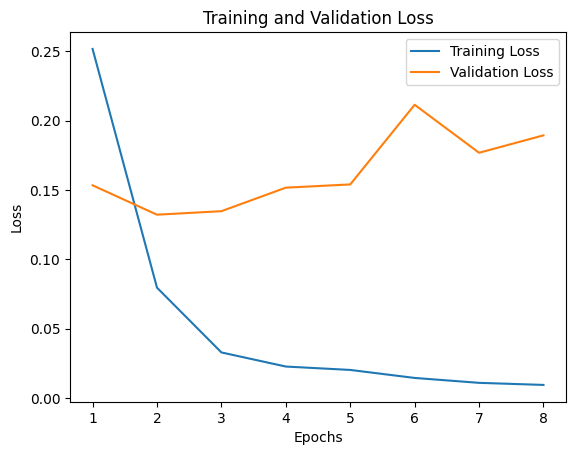

In [ ]:

epochs = 10
train_losses, val_losses = [], []
best_val_loss = float('inf')
patience = 6
no_improve_counter = 0

total_start_time = time.time()

for epoch in range(epochs):
    epoch_start_time = time.time()


    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)


    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")


    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improve_counter = 0
    else:
        no_improve_counter += 1
        if no_improve_counter >= patience:
            print("Validation loss 6 epoch boyunca iyileşmedi. Eğitim erken sonlandırılıyor.")
            break

total_training_time = time.time() - total_start_time
print(f"Total Training Time: {total_training_time:.2f} seconds")


plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()


In [ ]:

model_save_path = "/content/drive/MyDrive/swin_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model başarıyla kaydedildi: {model_save_path}")


Model başarıyla kaydedildi: /content/drive/MyDrive/swin_model.pth


Inference Time: 22.59 seconds
Inference Time per Sample: 0.003865 seconds


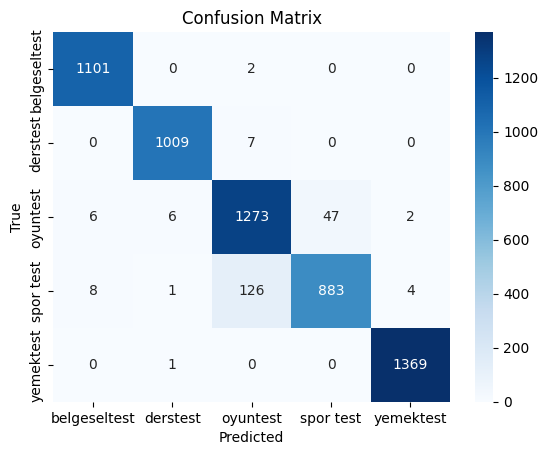

Accuracy: 0.9641
Precision: 0.9658
Recall: 0.9618
F1-Score: 0.9632
Sensitivity: 0.9618
Specificity: 0.9909


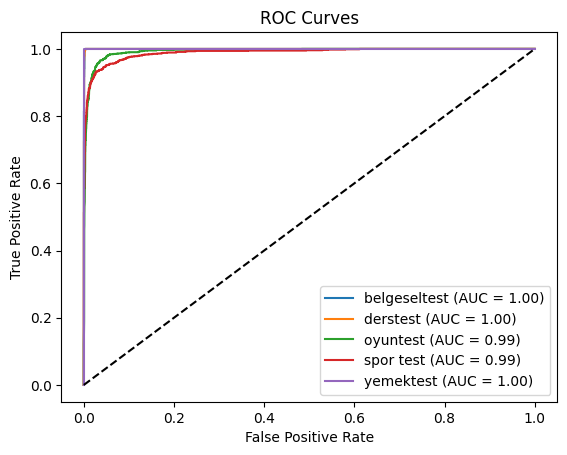

In [ ]:
import time
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc


inference_start_time = time.time()


all_labels = []
all_preds = []
all_probs = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

inference_end_time = time.time()
inference_time = inference_end_time - inference_start_time
num_samples = len(all_labels)
inference_time_per_sample = inference_time / num_samples

print(f"Inference Time: {inference_time:.2f} seconds")
print(f"Inference Time per Sample: {inference_time_per_sample:.6f} seconds")


cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=val_dataset.classes, yticklabels=val_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average="macro")
recall = recall_score(all_labels, all_preds, average="macro")
f1 = f1_score(all_labels, all_preds, average="macro")

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


sensitivity = recall
specificity = []
cm = cm.astype(np.float32)
for i in range(len(cm)):
    tn = np.sum(cm) - (np.sum(cm[i, :]) + np.sum(cm[:, i]) - cm[i, i])
    fp = np.sum(cm[:, i]) - cm[i, i]
    specificity.append(tn / (tn + fp))
specificity = np.mean(specificity)

print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

# ROC ve AUC
num_classes = len(val_dataset.classes)
y_true = np.eye(num_classes)[np.array(all_labels)]
all_probs = np.array(all_probs)

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{val_dataset.classes[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()


